# Perceptron Learning Algorithm
---
David Gillis

CS4340 - Machine Learning

Due: September 5, 2019 

---

## Assignment Description

Implement any variant of the perceptron learning algorithm for binary classification.

Generate 80 data points total, 40 from each class. Use 50 for training, and 30 for testing.
Consider two cases, one where the data is linearly seperable, and one where the data is not. 
Submit a single pdf file with the training data, source code, and results.

In addition, write responses to the following:

1. how (that is, following what logic)you generated the data points (training and test),
2. whether the training data points are linearly separable,
3. whether the test points are linearly separable,
4. your initial choice of the weights and constants,
5. the final solution equation of the line (decision boundary),
6. the total number of weight vector updates that your algorithm made,
7. the total number of iterations made over the training set(an iteration involves checking each of 
the training points and determining its class as given by the line), and
8. the final misclassification error, if any(expressed as a percentage), on the training data as well 
as on the test data.

Also, re-run your code (for both the above cases: linearly separable training set and not linearly 
separable training set) by varying the following and describe the effect, if any, that each of 
the three variations had on the final solution equation (test each of the three variations separately
and summarize your resultsin a numbered list): 

1. the initial choice of the weights,
2. the initial choice of the step size constant (c),
3. the order in which you consider the points in the training set.

In [1]:
# TODO:
# Generate more datasaets for testing the model
# Perform a grid search to answer the questions, above
# Add counters for epochs, iterations, and weight updates
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

## Preliminaries

We need a way to perform multiple initializations. I can think of two relatively good ways
to write initializers - the way I have done it here, and closures. I'd likely agree to
the argument that closures are easier to read. I digress . . . 

We create an `Initializer` base class which takes in `**kwargs` in the `__init__` method.
The keyword args are then saved in a class dictionary. Finally, when we `__call__` the
initializer, we pass off the arguments we passed in. This allows us to essentially 
create a function the same way we would in a closure.

Now, we can subclass the `Initializer`, and just provide any default arguments to
`param_dict`, as well as, a function for initialization. Might be worth researching
how this is done in Keras. In general, relying on subclassing is not maintainable. 

**Update**: I just read the Keras source, and I was super close. I'm going to keep the
old code in here because documenting my learning is beneficial. If this were 
production code, I'd remove it. I like the way Keras does this - and it follows my
thinking about closures - to use closures, you have to specify the arguments in the
definition of the closure, which is substantially more clear to the end user. 

For Reference:
[Keras Initializer](https://github.com/keras-team/keras/blob/fb7f49ef5b07f2ceee1d2d6c45f273df6672734c/keras/initializers.py#L14)

In [2]:
'''
class Initializer(object):
    def __init__(self, **kwargs):
        self.param_dict = kwargs
        self._init_fn = None
        
    def __call__(self, *args, **kwargs):
        return self._init_fn(**self.param_dict, **kwargs)
        
        
class StandardNormalInitializer(Initializer):
    def __init__(self, **kwargs):
        super(StandardNormalInitializer, self).__init__(**kwargs)
        self.param_dict['loc'] = 0.0
        self.param_dict['scale'] = 1.0
        self._init_fn = np.random.normal
        

class RandomNormalInitializer(Initializer):
    def __init__(self, **kwargs):
        super(RandomNormalInitializer, self).__init__(**kwargs)
        self._init_fn = np.random.normal
        
        
class ZeroInitializer(Initializer):
    def __init__(self, **kwargs):
        super(ZeroInitializer, self).__init__(**kwargs)
        self._init_fn = np.zeros
'''

"\nclass Initializer(object):\n    def __init__(self, **kwargs):\n        self.param_dict = kwargs\n        self._init_fn = None\n        \n    def __call__(self, *args, **kwargs):\n        return self._init_fn(**self.param_dict, **kwargs)\n        \n        \nclass StandardNormalInitializer(Initializer):\n    def __init__(self, **kwargs):\n        super(StandardNormalInitializer, self).__init__(**kwargs)\n        self.param_dict['loc'] = 0.0\n        self.param_dict['scale'] = 1.0\n        self._init_fn = np.random.normal\n        \n\nclass RandomNormalInitializer(Initializer):\n    def __init__(self, **kwargs):\n        super(RandomNormalInitializer, self).__init__(**kwargs)\n        self._init_fn = np.random.normal\n        \n        \nclass ZeroInitializer(Initializer):\n    def __init__(self, **kwargs):\n        super(ZeroInitializer, self).__init__(**kwargs)\n        self._init_fn = np.zeros\n"

In [3]:
class Initializer(object):
    def __call__(self, shape):
        raise NotImplementedError()
        

class ZeroInitializer(Initializer):
    def __call__(self, shape):
        return np.zeros(shape)
    

class RandomNormalInitializer(Initializer):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, shape):
        return np.random.normal(size=shape, loc=self.mean, scale=self.std)
    
    
class StandardNormalInitializer(Initializer):
    def __call__(self, shape):
        return np.random.normal(size=shape, loc=0.0, scale=1.0)
    

class ConstantInitializer(Initializer):
    def __init__(self, value):
        self.value = value
        
    def __call__(self, shape):
        return self.value * np.ones(shape=shape)

In [4]:
i = ConstantInitializer(value=20)
print(f'ConstantInitializer()(shape=10): {i(shape=10)}\n')

i = StandardNormalInitializer()
print(f'StandardNormalInitializer()(shape=10): {i(shape=10)}\n')

i = ZeroInitializer()
print(f'ZeroInitializer()(shape=10): {i(shape=10)}\n')

ConstantInitializer()(shape=10): [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]

StandardNormalInitializer()(shape=10): [ 0.22050613  0.23559109  0.81208167  0.64643976  0.18764823 -1.18941917
 -1.65299095 -0.05682123  0.86937369  0.91990963]

ZeroInitializer()(shape=10): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



We also need a few utility functions. The first is to shuffle two arrays in unison - we
need a way to be able to shuffle our predictors and targets together. 

Next, we need the sign function. This will be used in the prediction loop. Ideally, there
is a way to have this not applied element wise . . . I don't know what that is, I'll look
it up later.

In [5]:
def shuffle_arrays(a, b):
    """Shuffle two arrays with indicies."""
    if len(a) != len(b):
        raise ValueError('len(a) != len(b)')
    indices = np.random.permutation(len(a))
    return a[indices], b[indices] 


def sign(s):
    if s > 0:
        return 1
    else:
        return -1

## Model

For the perceptron itself, I'll explain the code in comments. I think it will be easier to follow
that way. With that said, the algorithm is as follows:


### PLA

1. Initialize the weights based on `initializer`. Default to zeros.
2. Until convergence, or maximum iterations:
    - Calculate the output $o:=sign(w^T x)$
    - If the sample is misclassified, update the weights
    according to $w_{t+1} = w_t + \eta y_t x_t$
    
### Pocket Learning Algorithm

1. Initialize the weights. Initialize the pocket based on the weights.
2. Until convergence, or maximum iterations:
    - Calculate the output $o:=sign(w^T x)$
    - If the sample is misclassified
        - update the weights
        according to $w_{t+1} = w_t + \eta y_t x_t$.
        - Compute the error for the pocket and the weights. If the
        error for the pocket is greater than the pocket error, update
        the pocket to the current weights.

In [6]:
class Perceptron(object):
    def __init__(self,
                 learning_rate=1.0,
                 maximum_iterations=1000,
                 tolerance=0.001,
                 shuffle_on_epoch=True,
                 initializer=None,
                 use_pocket=False,
                 **kwargs):
        """
        Initialize a perceptron learner.
        
        learning_rate : float 
            Rate to multiply the update by. Default 1.0.
        maximum_iterations : int
            Maximum number of iterations before stopping. 
        tolerance : float
            Error to reach before stopping.
        shuffle_on_epoch : bool
            Whether to shuffle the training data on each pass through. Default True.
        initializer : str
            How to initialize the weights. If not 'standard', arguments
            for the respective initialization method must be supplied.
        use_pocket : bool
            Whether to keep track of the best weight. Note that if `True`, 
            the runtime WILL increase. This is because to track the pocket,
            we have to compute the error on each update of the weights.
            
        Notes:
            This is not a performant learner, for a multitude of reasons,
            most notably that the `fit` method will make a copy of the 
            training data. While this is acceptable for this example, for
            large data sets, you'll start to hose your RAM. Only use on 
            toy datasets. 
            
            It is also assumed that your targets are in the set {-1, +1}.
            This is a large assumption, and it is one which would break 
            the algorithm as stated in other texts. However, we choose 
            to use the algorithm in the course text, which assumes the data
            is in this form. DO NOT feed data in any other form. If you do,
            the model IS NOT GUARANTEED to converge to a good solution, even
            for linearly seperable data. 
        """
        if initializer is None:
            self._initializer = ZeroInitializer()
        else:
            self._initializer = initializer
        self._learning_rate = learning_rate
        self._maximum_iterations = maximum_iterations
        self._tolerance = tolerance
        self._shuffle_on_epoch = shuffle_on_epoch
        self._use_pocket = use_pocket
        self._weights = None
        self._validate_input()
        
        # Telemetry
        self._iteration_counter = 0
        self._weight_update_counter = 0
        self._epoch_counter = 0
        self._is_training = False
    
    def fit(self, predictors, targets):
        """
        Fit the perceptron learner.
        predictors : numpy.ndarray (or array like, but don't blame me if it doesn't work)
            Predictors to train on.
        """
        if len(predictors.shape) != 2:
            raise ValueError(f'Invalid shape predictors.shape == {predictors.shape}')
        if len(targets.shape) != 1:
            raise ValueError(f'Invalid shape targets.shape == {targets.shape}')
        
        self._is_training = True
        
        # We only need to copy the dataset if we shuffle each epoch
        if self._shuffle_on_epoch:
            targets = np.copy(targets)

        # Copying the predictors is handled in the call. Not sure I like
        # that . . . TODO
        predictors = Perceptron._pad_first_column_ones(predictors)

        # Recall that we have a weight for the bias. This is already included
        # in the shape, because we padded the ones at the front. 
        cols = predictors.shape[1]
        self._weights = self._initializer(shape=(cols))
        
        # If the caller wants to use the pocket algorithm, we need to get the
        # initial weights.
        if self._use_pocket:
            pocket = np.copy(self.weights)
        
        lr = self._learning_rate
        # Iterate until we reach the maximum iteration, or until the error
        # is low enough to break.
        iterator, error = 0, np.inf
        while iterator < self._maximum_iterations and error > self._tolerance:
            # Iterate over every sample. Randomization is handled by shuffling.
            for predictor, target in zip(predictors, targets):
                # Compute the output
                prediction = sign(np.dot(self._weights, predictor))
                self._iteration_counter += 1
                # If misclassed, update according to the update rule. 
                if prediction != target:
                    update = lr * target * predictor
                    self._weights = self._weights + update
                    # If the caller wants to use pocket, compute
                    # the error and determine if the current weights
                    # give better performance.
                    if self._use_pocket:
                        pocket_predictions = self.predict(predictors, has_weights=True, weights_=pocket)
                        pocket_error = self.evaluate(pocket_predictions, targets)
                        current_iteration_predictions = self.predict(predictors, has_weights=True)
                        current_iteration_error = self.evaluate(current_iteration_predictions, targets)
                        if current_iteration_error < pocket_error:
                            pocket = np.copy(self._weights)
                iterator += 1
                
            # Compute the error for termination.
            predictions = self.predict(predictors, has_weights=True)
            error = self.evaluate(predictions, targets)
            # Shuffle as needed.
            if self._shuffle_on_epoch:
                predictors, targets = shuffle_arrays(predictors, targets)
        
        # If we are using pocket, set the weights to the pocket
        if self._use_pocket:
            self._weights = np.copy(pocket)
        
        self._is_training = False
        
        # Warn the caller if we didn't converge.
        if error > self._tolerance:
            warnings.warn('error > tolerance. Consider updating'
                          'maximum_iterations and running again.')
        
    def predict(self, predictors, has_weights=False, weights_=None):
        try:
            if weights_ == None:
                weights_ = self.weights
        except Exception:
            pass
    
        if not has_weights:
            predictors = Perceptron._pad_first_column_ones(predictors)
        predictions = []
        for predictor in predictors:
            predictions.append(sign(np.dot(weights_, predictor)))
            if self._is_training:
                self._iteration_counter += 1
        return np.array(predictions)

    def evaluate(self, predicted, actual):
        # Again, likely a better way to do this.
        if len(predicted) != len(actual):
            raise ValueError('len(predicted) != len(actual)')
        correct = sum(predicted == actual) * 1.0
        return 1.0 - (correct / len(actual))
    
    @property
    def weights(self):
        return self._weights
    
    @property
    def iteration_counter(self):
        '''
        The `iteration_counter` is defined as:
            Checking each of the training points and determining its class.
            That is, the number of times we computed the class for a point.
            
        Reset during training.
        '''
        return self._iteration_counter
    
    @staticmethod
    def _pad_first_column_ones(predictors):
        rows, cols = predictors.shape
        predictors = np.concatenate([np.ones((rows, 1)), predictors], axis=1)
        return predictors
    
    def _validate_input(self):
        if self._learning_rate <= 0:
            raise ValueError('learning_rate must be > 0')
        if self._maximum_iterations <= 0:
            raise ValueError('maximum_iterations must be > 0')
        if self._tolerance < 0:
            raise ValueError('tolerance must be >= 0')
    

## Training & Testing

I originally intended to perform a grid search for the samples I generate. I
wrote like 90% of the assignment, then started working on my OS project. It's
now 09.04.2019. If I have time, I'll implement one. Until then, I'm going to
just generate the datasets I need and do testing manually. 

We need some functions to help with plotting.

In [7]:
def plot_decisions(model, predictors, targets):
    """
    Inspired by https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html
    """
    x_min, x_max = predictors[:, 0].min() - 1, predictors[:, 0].max() + 1
    y_min, y_max = predictors[:, 1].min() - 1, predictors[:, 1].max() + 1
    x, y = np.meshgrid(
        np.arange(x_min, x_max, 0.1),
        np.arange(y_min, y_max, 0.1)
    )
    z = model.predict(np.c_[x.ravel(), y.ravel()])
    z = z.reshape(x.shape)
    plt.contourf(x, y, z)
    plt.scatter(x=predictors[:, 0], y=predictors[:, 1], c=targets, edgecolor='k')
    plt.show()
    
def plot_train_test(train_x, train_y, test_x, test_y):
    plt.subplot(2, 2, 1)
    plt.scatter(x=train_x[:, 0], y=train_x[:, 1], c=train_y)
    plt.title('Training Data')

    plt.subplot(2, 2, 2)
    plt.scatter(x=test_x[:, 0], y=test_x[:, 1], c=test_y)
    plt.title('Testing Data')

    plt.show()

### Linearly Seperable Data

We begin by generating data that is *clearly* linearly seperable. Note that
`numpy.random.sample` generates random uniform data in the half open interval
$[0, 1)$. We scale the positive samples up by $2$ for seperability. The choice
of $2$ is somewhat arbitrary. This could be any real number in the range 
$(1, \infty)$, bounded only by the range of double precision floating point
numbers. 

In [8]:
pos = np.random.sample((40, 2)) + 2
neg = np.random.sample((40, 2))
pos_targets = np.ones(40)
neg_targets = np.zeros(40) - 1

x = np.concatenate([pos, neg], axis=0)
y = np.concatenate([pos_targets, neg_targets], axis=0)

x, y = shuffle_arrays(x, y)

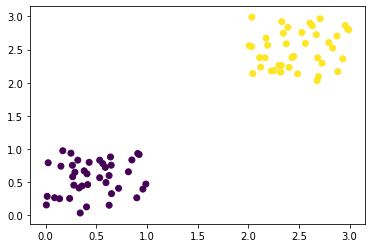

In [9]:
plt.scatter(x=x[:, 0], y=x[:, 1], c=y)

#### Train Test Split

This is not the exact specification for the project, but it is the correct way to
do this. We take the shuffled samples and targets, allowing us to randomly sample
$50$ training points and $30$ testing points by index.

In [10]:
x_train, x_test = x[:50], x[50:]
y_train, y_test = y[:50], y[50:]
x_train.shape, y_train.shape

((50, 2), (50,))

In [11]:
x_test.shape, y_test.shape

((30, 2), (30,))

Put the data into a dataframe so we can display it here. We will not use this dataframe again.

In [12]:
data_train = pd.DataFrame(np.concatenate([x_train, y_train.reshape(-1, 1)], axis=1))
data_test = pd.DataFrame(np.concatenate([x_test, y_test.reshape(-1, 1)], axis=1))

In [13]:
data_train

,0,1,2
0,2.320671,2.160231,1.0
1,0.430519,0.801082,-1.0
2,2.563732,2.594752,1.0
3,2.448585,2.398948,1.0
4,2.678703,2.033393,1.0
5,0.596497,0.495960,-1.0
6,2.302004,2.261927,1.0
7,2.122793,2.236277,1.0
8,2.330556,2.921616,1.0
9,0.589968,0.724632,-1.0


In [14]:
data_test

,0,1,2
0,0.627533,0.154482,-1.0
1,0.016302,0.287929,-1.0
2,2.875298,2.705927,1.0
3,0.404419,0.128596,-1.0
4,0.089713,0.267025,-1.0
5,0.318374,0.833680,-1.0
6,2.390583,2.835430,1.0
7,2.883283,2.169029,1.0
8,0.627103,0.601824,-1.0
9,2.430885,2.380470,1.0


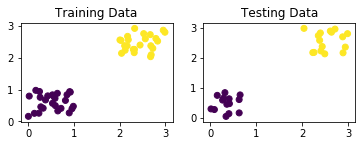

In [15]:
plot_train_test(x_train, y_train, x_test, y_test)

#### Fitting

We iterate several times using two initializer strategies. This allows us to compute means for a
few metrics. We also switch between the pocket and PLA algorithms for comparison.

In [16]:
standard_normal_errors = []
zero_errors = []
standard_normal_iter_count = []
zero_iter_count = []

for use_pocket in [True, False]:
    print(f'[+] Using Pocket Algorithm: {use_pocket}')
    for c in [0.1, 0.2, 0.5, 1.0]:
        print(f'\t[+] Learning Rate: {c}')
        for i in range(100):
            model_standard_normal = Perceptron(
                initializer=StandardNormalInitializer(), use_pocket=use_pocket,
                learning_rate=c
            )
            model_zero = Perceptron(
                initializer=ZeroInitializer(), use_pocket=use_pocket,
                learning_rate=c
            )

            model_standard_normal.fit(x_train, y_train)
            model_zero.fit(x_train, y_train)

            # Make predictions
            standard_normal_predictions = model_standard_normal.predict(x_test)
            standard_normal_errors.append(model_standard_normal.evaluate(standard_normal_predictions, y_test))

            zero_predictions = model_zero.predict(x_test)
            zero_errors.append(model_zero.evaluate(zero_predictions, y_test))

            # Append the iteration counts
            standard_normal_iter_count.append(model_standard_normal.iteration_counter)
            zero_iter_count.append(model_zero.iteration_counter)

        mean_iteration_count_standard_norm = sum(standard_normal_iter_count) / len(standard_normal_iter_count)
        mean_iteration_count_zero = sum(zero_iter_count) / len(zero_iter_count)

        mean_error_standard_norm = sum(standard_normal_errors) / len(standard_normal_errors)
        mean_error_zero = sum(zero_errors) / len(zero_errors)

        print(
            f'\t\t[+] Average Iteration Count W/ Zero Initializer PLA: {mean_iteration_count_zero}')
        print(
    f'\t\t[+] Average Iteration Count W/ Standard Normal Initializer PLA: {mean_iteration_count_standard_norm}')

        print(f'\t\t[+] Average Error W/ Zero Initializer: {mean_error_zero}')
        print(f'\t\t[+] Average Error W/ Standard Normal Initializer: {mean_error_standard_norm}')

[+] Using Pocket Algorithm: True
	[+] Learning Rate: 0.1
		[+] Average Iteration Count W/ Zero Initializer PLA: 1300.0
		[+] Average Iteration Count W/ Standard Normal Initializer PLA: 1936.0
		[+] Average Error W/ Zero Initializer: 0.0
		[+] Average Error W/ Standard Normal Initializer: 0.004666666666666665
	[+] Learning Rate: 0.2
		[+] Average Iteration Count W/ Zero Initializer PLA: 1300.0
		[+] Average Iteration Count W/ Standard Normal Initializer PLA: 1546.5
		[+] Average Error W/ Zero Initializer: 0.0
		[+] Average Error W/ Standard Normal Initializer: 0.002999999999999999
	[+] Learning Rate: 0.5
		[+] Average Iteration Count W/ Zero Initializer PLA: 1300.0
		[+] Average Iteration Count W/ Standard Normal Initializer PLA: 1333.0
		[+] Average Error W/ Zero Initializer: 0.0
		[+] Average Error W/ Standard Normal Initializer: 0.0021111111111111105
	[+] Learning Rate: 1.0
		[+] Average Iteration Count W/ Zero Initializer PLA: 1300.0
		[+] Average Iteration Count W/ Standard Normal 

In [17]:
p = Perceptron(initializer=StandardNormalInitializer(), use_pocket=True)
p.fit(x_train, y_train)

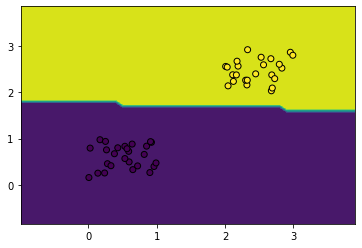

In [18]:
plot_decisions(p, x_train, y_train)

In [19]:
p = Perceptron(initializer=StandardNormalInitializer(), use_pocket=False)
p.fit(x_train, y_train)

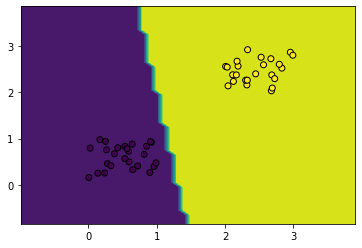

In [20]:
plot_decisions(p, x_train, y_train)

#### Linearly Seperable Summary

As we can see, when the data is linearly seperable, given enough iterations, the model is
capable of finding a sufficiently good decision boundary, regardless of whether the pocket
variant is being used. This is shown in the two somewhat arbitrary boundaries drawn above.

As should be expected, the pocket algorithm takes longer to converge than the non-pocket
variant. Note that we count iterations based on times to test the accuracy of a sample. So,
because the pocket algorithm has to compute the error any time a weight change happens, it
is slower. 

More interestingly, using standard normal initialization results in faster convergence for
both variants of the model. However, it also results in a higher error.

Last, we also vary the learning rate from $0.1$ to $1.0$. We note that an increased learning
rate generally leads to increase convergence, bounded by $1$.

### Linearly Non-Seperable Data

We again generate data, but this time we allow some overlap so that there must be *some* error.

In [21]:
pos = np.random.sample((40, 2)) + .6
neg = np.random.sample((40, 2))
pos_targets = np.ones(40)
neg_targets = np.zeros(40) - 1

x = np.concatenate([pos, neg], axis=0)
y = np.concatenate([pos_targets, neg_targets], axis=0)

x, y = shuffle_arrays(x, y)

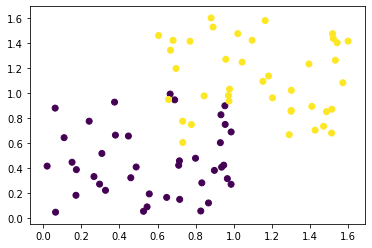

In [22]:
plt.scatter(x=x[:, 0], y=x[:, 1], c=y)

In [23]:
x_train, x_test = x[:50], x[50:]
y_train, y_test = y[:50], y[50:]

In [24]:
data_train = pd.DataFrame(np.concatenate([x_train, y_train.reshape(-1, 1)], axis=1))
data_test = pd.DataFrame(np.concatenate([x_test, y_test.reshape(-1, 1)], axis=1))

In [25]:
data_train

,0,1,2
0,0.296024,0.273828,-1.0
1,1.290952,0.667821,1.0
2,0.374572,0.927510,-1.0
3,0.986108,0.689708,-1.0
4,1.021163,1.473501,1.0
5,1.518315,1.473036,1.0
6,0.447213,0.657175,-1.0
7,0.241338,0.775321,-1.0
8,0.526416,0.057075,-1.0
9,0.174090,0.389045,-1.0


In [26]:
data_test

,0,1,2
0,0.732442,0.605676,1.0
1,1.301638,0.860916,1.0
2,0.556628,0.195655,-1.0
3,0.065102,0.049863,-1.0
4,0.799192,0.480099,-1.0
5,0.932710,0.826623,-1.0
6,0.545136,0.092173,-1.0
7,0.308122,0.518125,-1.0
8,0.605598,1.459011,1.0
9,0.985835,0.272342,-1.0


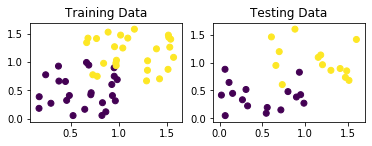

In [27]:
plot_train_test(x_train, y_train, x_test, y_test)

In [28]:
standard_normal_errors = []
zero_errors = []
standard_normal_iter_count = []
zero_iter_count = []

for use_pocket in [True, False]:
    print(f'[+] Using Pocket Algorithm: {use_pocket}')
    for c in [0.1, 0.2, 0.5, 1.0]:
        print(f'\t[+] Learning Rate: {c}')
        for i in range(100):
            model_standard_normal = Perceptron(
                initializer=StandardNormalInitializer(), use_pocket=use_pocket,
                learning_rate=c
            )
            model_zero = Perceptron(
                initializer=ZeroInitializer(), use_pocket=use_pocket,
                learning_rate=c
            )

            model_standard_normal.fit(x_train, y_train)
            model_zero.fit(x_train, y_train)

            # Make predictions
            standard_normal_predictions = model_standard_normal.predict(x_test)
            standard_normal_errors.append(model_standard_normal.evaluate(standard_normal_predictions, y_test))

            zero_predictions = model_zero.predict(x_test)
            zero_errors.append(model_zero.evaluate(zero_predictions, y_test))

            # Append the iteration counts
            standard_normal_iter_count.append(model_standard_normal.iteration_counter)
            zero_iter_count.append(model_zero.iteration_counter)

        mean_iteration_count_standard_norm = sum(standard_normal_iter_count) / len(standard_normal_iter_count)
        mean_iteration_count_zero = sum(zero_iter_count) / len(zero_iter_count)

        mean_error_standard_norm = sum(standard_normal_errors) / len(standard_normal_errors)
        mean_error_zero = sum(zero_errors) / len(zero_errors)

        print(
            f'\t\t[+] Average Iteration Count W/ Zero Initializer PLA: {mean_iteration_count_zero}')
        print(
    f'\t\t[+] Average Iteration Count W/ Standard Normal Initializer PLA: {mean_iteration_count_standard_norm}')

        print(f'\t\t[+] Average Error W/ Zero Initializer: {mean_error_zero}')
        print(f'\t\t[+] Average Error W/ Standard Normal Initializer: {mean_error_standard_norm}')

[+] Using Pocket Algorithm: True
	[+] Learning Rate: 0.1


/home/das-hund/.conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:134: UserWarning: error > tolerance. Consider updatingmaximum_iterations and running again.


		[+] Average Iteration Count W/ Zero Initializer PLA: 17122.0
		[+] Average Iteration Count W/ Standard Normal Initializer PLA: 17449.0
		[+] Average Error W/ Zero Initializer: 0.0773333333333332
		[+] Average Error W/ Standard Normal Initializer: 0.08099999999999985
	[+] Learning Rate: 0.2
		[+] Average Iteration Count W/ Zero Initializer PLA: 17161.5
		[+] Average Iteration Count W/ Standard Normal Initializer PLA: 17137.0
		[+] Average Error W/ Zero Initializer: 0.07633333333333313
		[+] Average Error W/ Standard Normal Initializer: 0.07916666666666645
	[+] Learning Rate: 0.5
		[+] Average Iteration Count W/ Zero Initializer PLA: 17210.0
		[+] Average Iteration Count W/ Standard Normal Initializer PLA: 17087.333333333332
		[+] Average Error W/ Zero Initializer: 0.07622222222222214
		[+] Average Error W/ Standard Normal Initializer: 0.07799999999999993
	[+] Learning Rate: 1.0
		[+] Average Iteration Count W/ Zero Initializer PLA: 17198.25
		[+] Average Iteration Count W/ Standard No

/home/das-hund/.conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:134: UserWarning: error > tolerance. Consider updatingmaximum_iterations and running again.


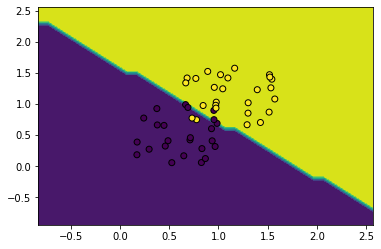

In [29]:
p = Perceptron(initializer=StandardNormalInitializer(), use_pocket=True)
p.fit(x_train, y_train)
plot_decisions(p, x_train, y_train)

/home/das-hund/.conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:134: UserWarning: error > tolerance. Consider updatingmaximum_iterations and running again.


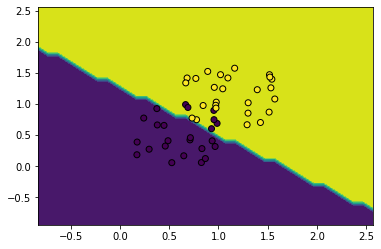

In [30]:
p = Perceptron(initializer=StandardNormalInitializer(), use_pocket=False)
p.fit(x_train, y_train)
plot_decisions(p, x_train, y_train)

#### Linearly Non-Seperable Summary

As we know, if the data is not linearly seperable, the model is not capable of making a
decision boundary that cleanly classifies all instances. With that in mind, we can make
some observations.

Again, the pocket algorithm takes longer to converge than the non pocket variant. Moreover,
any increase in accuracy is marginal at best. 

Next, we note that unlike the linearly seperable case, the standard normal initialization does
not lead to a speed up in convergence. In fact, in many cases, it has the opposite effect. 

Last, for the pocket variant, a higher learning rate leads to faster convergence.